In [13]:
#Импортируем библиотеки
from multiprocessing import Pool
import codecs
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot
%matplotlib inline

In [14]:
data = pd.read_csv("posts_all.csv", encoding="utf-8")
data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1346 entries, 0 to 1941
Data columns (total 7 columns):
Id           1346 non-null int64
Text         1346 non-null object
Sentiment    1346 non-null float64
Created      1346 non-null object
Modified     1346 non-null object
Splitted     1346 non-null object
GroupId      1346 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 84.1+ KB


,Id,Text,Sentiment,Created,Modified,Splitted,GroupId
1937,4831,"Hi, Helen, \r\nThanks very much. \r\nYour ap...",3.0,2018-12-02 00:00:00.000,2018-12-02 00:00:00.000,2018-12-02 00:00:00.000,8.0
1938,4832,Thank you very much for your help Brendon! \r...,3.0,2018-12-02 00:00:00.000,2018-12-02 00:00:00.000,2018-12-02 00:00:00.000,8.0
1939,4833,Thank you Svetlana that makes sense and now wo...,4.0,2018-12-02 00:00:00.000,2018-12-02 00:00:00.000,2018-12-02 00:00:00.000,8.0
1940,4834,Thanks very much Alex. \r\nRun speed and ok! ...,3.0,2018-12-02 00:00:00.000,2018-12-02 00:00:00.000,2018-12-02 00:00:00.000,8.0
1941,4835,This was exactly what i was looking for. \r\n...,3.0,2018-12-02 00:00:00.000,2018-12-02 00:00:00.000,2018-12-02 00:00:00.000,8.0


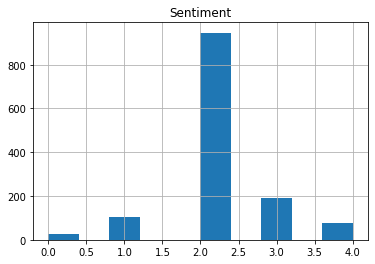

In [15]:
data.info()
#Гистограмма распределения классов 
data.hist(column=["Sentiment"])
data.tail()


In [31]:
#The data store in really imbalanced
#Let's try the over sampling technice

import random 
classes = np.unique(data.Sentiment.values)
amount_classes = data.groupby("Sentiment").count().Id.values
max_amount = max(amount_classes)
for cl_index in range(len(classes)):
    cl = classes[cl_index]
    cl_slice = data[data.Sentiment == cl]
    amount = amount_classes[cl_index]
    samples_to_add = max_amount - amount
    while samples_to_add > 0:
        sample_index = random.randint(0, amount - 1)

        data = data.append(cl_slice.iloc[sample_index])
        samples_to_add -= 1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4730 entries, 0 to 87
Data columns (total 7 columns):
Id           4730 non-null int64
Text         4730 non-null object
Sentiment    4730 non-null float64
Created      4730 non-null object
Modified     4730 non-null object
Splitted     4730 non-null object
GroupId      4730 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 295.6+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018268D98CC0>,
      dtype=object)

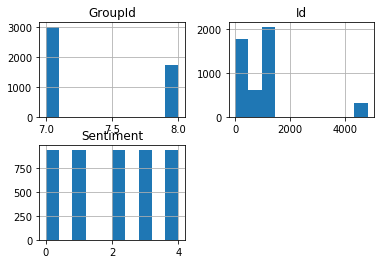

In [32]:
data.info()
data.hist(column=["Sentiment"])

In [26]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC

data["target"] = data.Sentiment.apply(lambda x: 1 if x > 2 else 0 if x < 2 else 0.5)

X = data.Text.values
Y = data.target.values

In [29]:
#Импортируем доп библиотеки
from sklearn.pipeline import Pipeline
#Подбор лучших параметров
from sklearn.model_selection import GridSearchCV

#Функция создания каскада - пайплайна из ветроризатора, трансформатора и класификатора
def text_classifier(vectorizer, classifier, transformer=None):
    if (transformer is None) :
        return Pipeline(
                [("vectorizer", vectorizer),
                 ("classifier", classifier)]
            )
    else: 
        return Pipeline(
            [("vectorizer", vectorizer),
             ("transformer", transformer),
            ("classifier", classifier)]
        )

In [30]:
# the best parameters search for the level 1 estimator
ngram_range = [(2,4),(2,5),(3,5),(2,6),(3,6),(4,6)]
param_grid = {
    "vectorizer": [TfidfVectorizer(), CountVectorizer()],
    "vectorizer__analyzer": ["char", "char_wb", "word"],
    "vectorizer__ngram_range": ngram_range,
    "vectorizer__stop_words": [None, "english"],
    "classifier": [LinearRegression()],
    "vectorizer__max_df": np.arange(0.95, 1.0, 0.02),
    #"vectorizer__min_df": np.arange(0.0, 0.10, 0.05),
}

pipLine = text_classifier(CountVectorizer(), LinearSVC())
gridSearchCV = GridSearchCV(pipLine, scoring="max_error", 
                            param_grid=param_grid,
                            cv=5,
                           )
gridSearchCV.fit(X, Y)

print("best params", gridSearchCV.best_params_)
print("best score", gridSearchCV.best_score_)

best params {'classifier': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False), 'vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.95, max_features=None, min_df=1,
                ngram_range=(4, 6), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None), 'vectorizer__analyzer': 'word', 'vectorizer__max_df': 0.95, 'vectorizer__ngram_range': (4, 6), 'vectorizer__stop_words': 'english'}
best score -0.5650080925755924


C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
# the best parameters search for the level 2 estimator

Y_classes = data.Sentiment.values

ngram_range = [(2,4),(2,5),(3,5),(2,6),(3,6),(4,6)]
param_grid = {
    "vectorizer": [TfidfVectorizer(), CountVectorizer()],
    "vectorizer__analyzer": ["char", "char_wb", "word"],
    "vectorizer__ngram_range": ngram_range,
    "vectorizer__stop_words": [None, "english"],
    "classifier": [LogisticRegression(multi_class="multinomial", 
                                      solver="lbfgs",
                                      max_iter=120   
                                     )],
    "vectorizer__max_df": np.arange(0.95, 1.0, 0.02),
    #"vectorizer__min_df": np.arange(0.0, 0.10, 0.05),
}

pipLine = text_classifier(CountVectorizer(), LogisticRegression())
gridSearchCV = GridSearchCV(pipLine, 
                            cv=5,
                            param_grid=param_grid)
gridSearchCV.fit(X, Y_classes)

print("best params", gridSearchCV.best_params_)
print("best score", gridSearchCV.best_score_)

In [52]:
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(4, 6), max_df=0.95)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_vec, Y, test_size=0.33)


linear_classifier = LinearRegression()
linear_classifier.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
print("Train",
      linear_classifier.score(X_train, Y_train),
      "Test",
      linear_classifier.score(X_test, Y_test))

Train 0.999999999999989 Test 0.36434815621977945


In [54]:
l2_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_df=0.95)
X_vec_l2 = l2_vectorizer.fit_transform(X)

linear_estimation = np.array([list([v]) for v in linear_classifier.predict(X_vec)])
X_epanded = np.hstack((X_vec_l2.toarray(), linear_estimation))
Y_classes = data.Sentiment.apply(lambda x: 1 if x > 2 else -1 if x < 2 else 0).values

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X_epanded, Y_classes, test_size=0.33)


log_classifier = LogisticRegression(solver="lbfgs", 
                                    multi_class="ovr")
log_classifier.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
print("Train",
      log_classifier.score(X_train, Y_train),
      "Test",
      log_classifier.score(X_test, Y_test))

print(cross_val_score(log_classifier, X_epanded, Y_classes, cv=5))

Train 0.9389567147613762 Test 0.8898876404494382
[0.89298893 0.8962963  0.88104089 0.87686567 0.91791045]


In [57]:
print(len(X) - 1)
test_index = 1345
print(X[test_index],
      "Prediction - ",
      log_classifier.predict([X_epanded[test_index]])[0])
print("The real value is - ",
     Y_classes[test_index])
print(log_classifier.predict_proba([X_epanded[test_index]]))

1345
This was exactly what i was looking for.  
Thank you Yulia for your help. Prediction -  1
The real value is -  1
[[0.00823931 0.30631146 0.68544923]]


In [58]:
import pickle
#Сохранение данных в файл с помощью pickle
pickle.dump(linear_classifier, open( "l1_Classifier.pkl", "wb" ))
pickle.dump(vectorizer, open( "l1_vectorizer.pkl", "wb" ))
pickle.dump(log_classifier, open( "l2_Classifier.pkl", "wb" ))
pickle.dump(l2_vectorizer, open( "l2_vectorizer.pkl", "wb" ))